## Plot the data

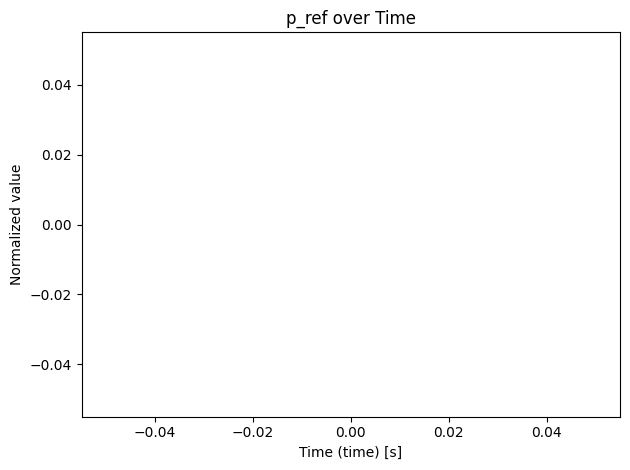

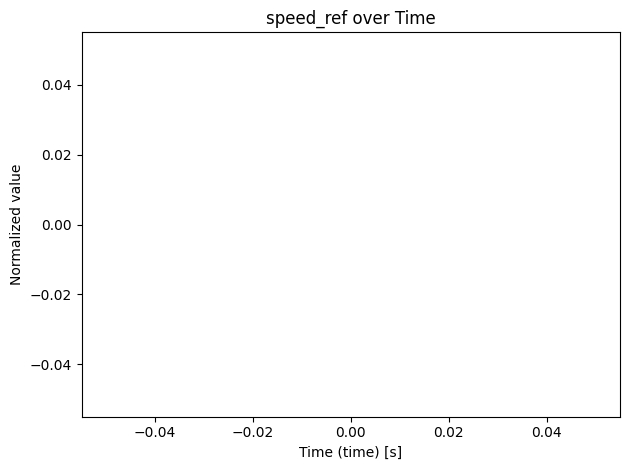

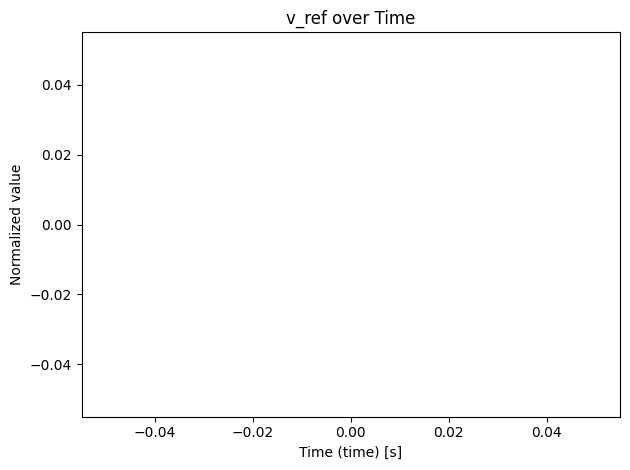

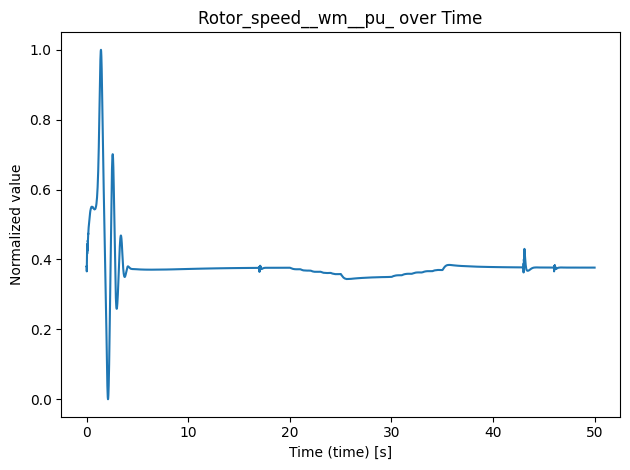

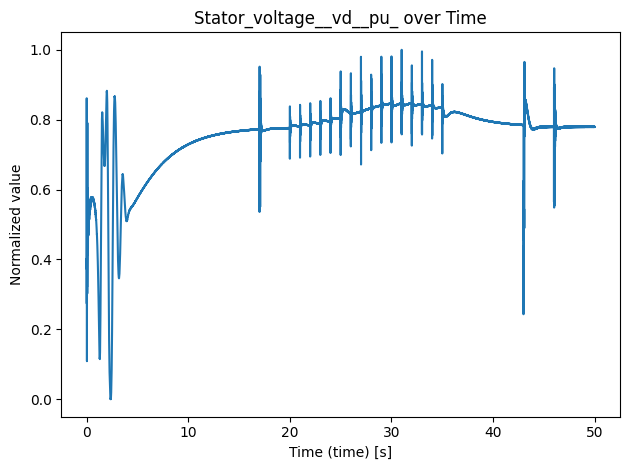

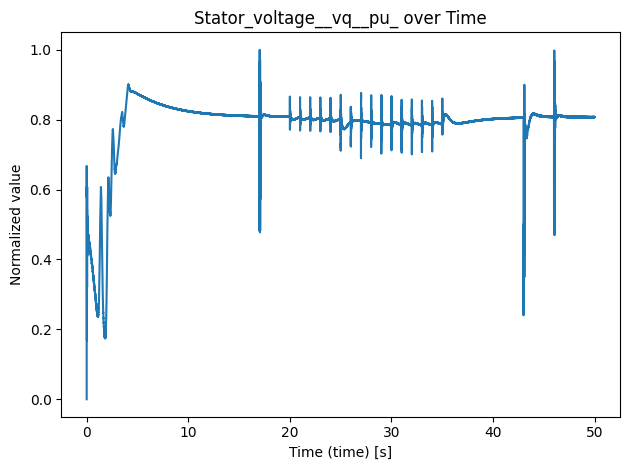

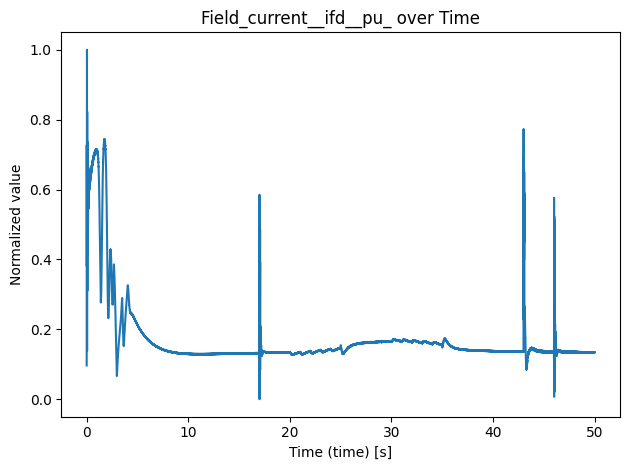

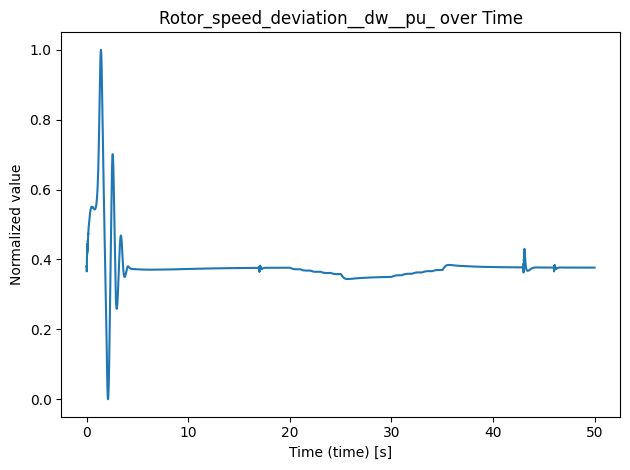

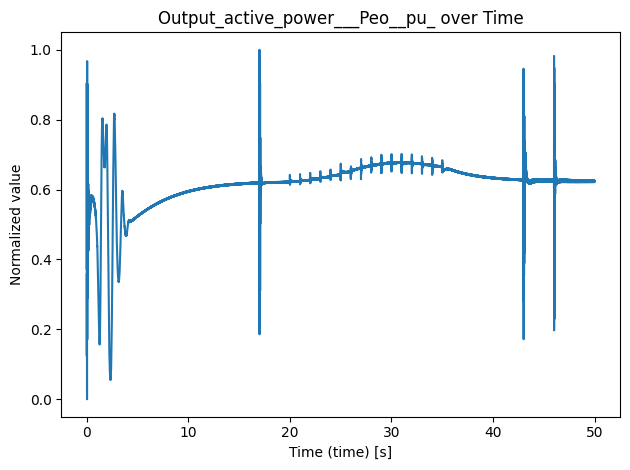

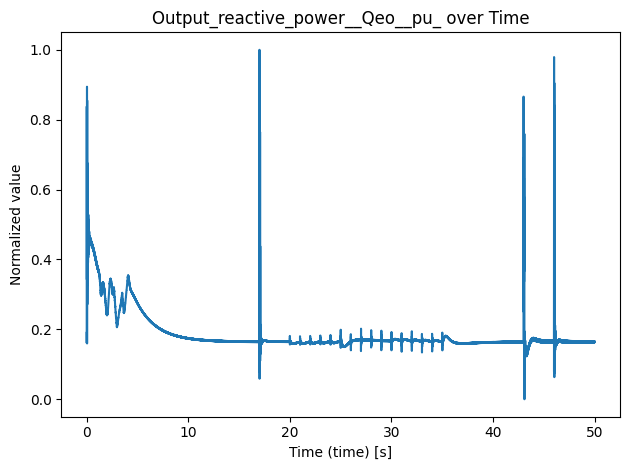

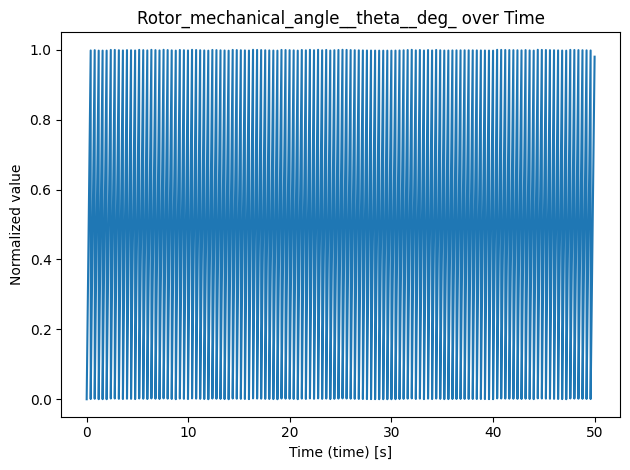

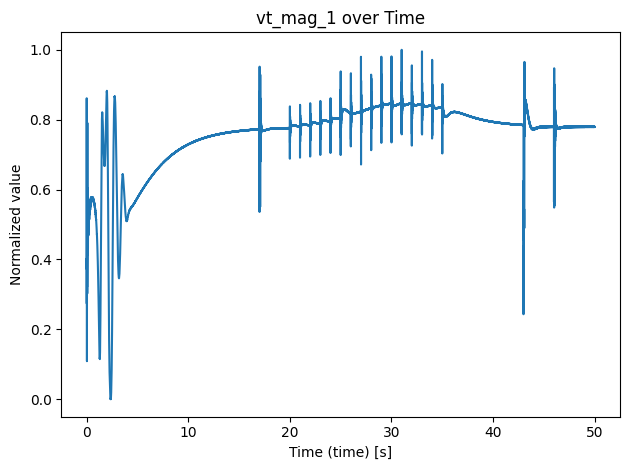

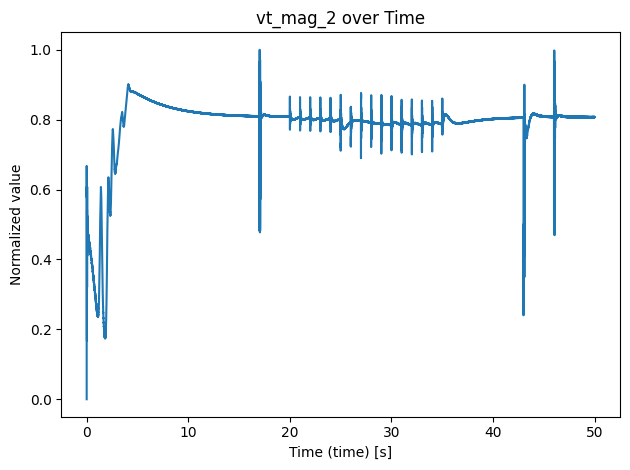

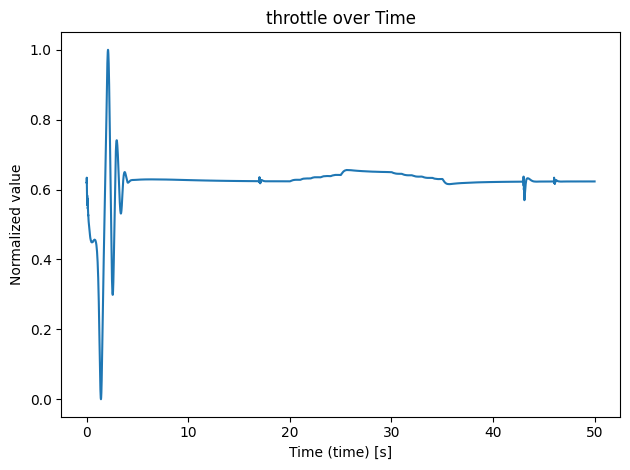

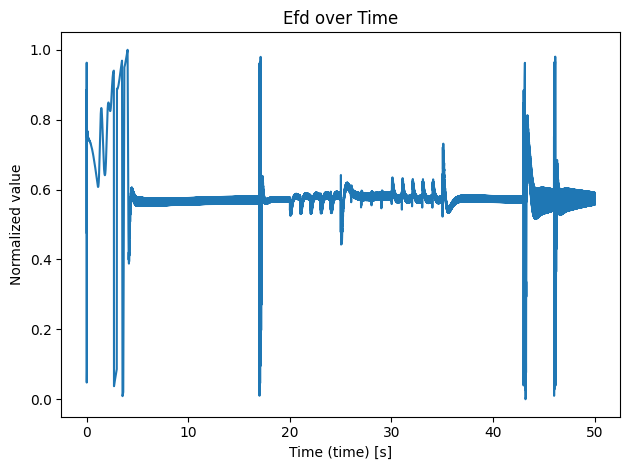

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV (adjust path if needed)
file_path = 'signals_exported.csv'
df = pd.read_csv(file_path)

# Identify the time column
time_col = df.columns[0]

# Min–max normalize all signal columns
df_norm = df.copy()
for col in df.columns[1:]:
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Plot each normalized signal in its own figure
for col in df_norm.columns[1:]:
    plt.figure()
    plt.plot(df_norm[time_col], df_norm[col])
    plt.xlabel(f'Time ({time_col}) [s]')
    plt.ylabel('Normalized value')
    plt.title(f'{col} over Time')
    plt.tight_layout()
    plt.show()


In [8]:
import pandas as pd
import numpy as np
from scipy.fft import fft
import pywt

# ------------------------------
# Reload the data and set time index
# ------------------------------
df = pd.read_csv('signals_exported.csv')
time_col = df.columns[0]
df.set_index(time_col, inplace=True)

# ------------------------------
# Helper functions
# ------------------------------
def align_series(ts1, ts2):
    common_index = ts1.index.intersection(ts2.index)
    return ts1.loc[common_index], ts2.loc[common_index]

def euclidean_distance(ts1, ts2):
    s1, s2 = align_series(ts1, ts2)
    return np.linalg.norm(s1.values - s2.values) if len(s1) else np.nan

def fft_euclidean_distance(ts1, ts2):
    s1, s2 = align_series(ts1, ts2)
    return np.linalg.norm(np.abs(fft(s1.values)) - np.abs(fft(s2.values))) if len(s1) else np.nan

def kl_divergence(p, q, eps=1e-10):
    p = p + eps; q = q + eps
    return np.sum(p * np.log(p / q))

def symmetric_kl(ts1, ts2, eps=1e-10):
    s1, s2 = align_series(ts1, ts2)
    if not len(s1):
        return np.nan
    arr1 = s1.values - s1.values.min()
    arr2 = s2.values - s2.values.min()
    p = arr1 / (arr1.sum() + eps)
    q = arr2 / (arr2.sum() + eps)
    return 0.5 * (kl_divergence(p, q, eps) + kl_divergence(q, p, eps))

def wavelet_energy_distance(ts1, ts2, wavelet='db1', level=None):
    s1, s2 = align_series(ts1, ts2)
    if not len(s1):
        return np.nan
    coeffs1 = pywt.wavedec(s1.values, wavelet, level=level)
    coeffs2 = pywt.wavedec(s2.values, wavelet, level=level)
    e1 = np.array([np.sum(c**2) for c in coeffs1])
    e2 = np.array([np.sum(c**2) for c in coeffs2])
    e1 /= e1.sum(); e2 /= e2.sum()
    return np.linalg.norm(e1 - e2)

# ------------------------------
# Select column groups
# ------------------------------
cols_4_13 = df.columns[3:13]
cols_14_15 = df.columns[13:15]

# ------------------------------
# Compute and print tables
# ------------------------------
metrics = {
    'Euclidean Distance': euclidean_distance,
    'FFT-Euclid Distance': fft_euclidean_distance,
    'Symmetric KL': symmetric_kl,
    'Wavelet-Energy Dist': wavelet_energy_distance
}

for name, func in metrics.items():
    table = pd.DataFrame(index=cols_4_13, columns=cols_14_15, dtype=float)
    for c1 in cols_4_13:
        for c2 in cols_14_15:
            table.loc[c1, c2] = func(df[c1], df[c2])
    print(f"\n{name}:\n")
    print(table)



Euclidean Distance:

                                         throttle           Efd
Rotor_speed__wm__pu_                   132.435453    269.653847
Stator_voltage__vd__pu_                148.200743    348.810308
Stator_voltage__vq__pu_                114.908675    284.736930
Field_current__ifd__pu_                236.969249    250.233360
Rotor_speed_deviation__dw__pu_         210.075549    395.825872
Output_active_power___Peo__pu_         120.500997    309.837335
Output_reactive_power__Qeo__pu_        231.718202    393.005741
Rotor_mechanical_angle__theta__deg_  46318.245674  46205.704109
vt_mag_1                               148.200743    348.810308
vt_mag_2                               114.908675    284.736930

FFT-Euclid Distance:

                                         throttle           Efd
Rotor_speed__wm__pu_                 2.911973e+04  6.019083e+04
Stator_voltage__vd__pu_              3.132185e+04  7.397826e+04
Stator_voltage__vq__pu_              2.385965e+04  5.890581

In [10]:
import pandas as pd
import numpy as np
from scipy.fft import fft
import pywt

# ------------------------------
# Reload the data and set time index
# ------------------------------
df = pd.read_csv('signals_exported.csv')
time_col = df.columns[0]
df.set_index(time_col, inplace=True)

# ------------------------------
# Helper functions
# ------------------------------
def align_series(ts1, ts2):
    common_index = ts1.index.intersection(ts2.index)
    return ts1.loc[common_index], ts2.loc[common_index]

def euclidean_distance(ts1, ts2):
    s1, s2 = align_series(ts1, ts2)
    return np.linalg.norm(s1.values - s2.values) if len(s1) else np.nan

def fft_euclidean_distance(ts1, ts2):
    s1, s2 = align_series(ts1, ts2)
    return np.linalg.norm(np.abs(fft(s1.values)) - np.abs(fft(s2.values))) if len(s1) else np.nan

def kl_divergence(p, q, eps=1e-10):
    p = p + eps; q = q + eps
    return np.sum(p * np.log(p / q))

def symmetric_kl(ts1, ts2, eps=1e-10):
    s1, s2 = align_series(ts1, ts2)
    if not len(s1): return np.nan
    arr1 = s1.values - s1.values.min()
    arr2 = s2.values - s2.values.min()
    p = arr1 / (arr1.sum() + eps)
    q = arr2 / (arr2.sum() + eps)
    return 0.5 * (kl_divergence(p, q) + kl_divergence(q, p))

def wavelet_energy_distance(ts1, ts2, wavelet='db1', level=None):
    s1, s2 = align_series(ts1, ts2)
    if not len(s1): return np.nan
    coeffs1 = pywt.wavedec(s1.values, wavelet, level=level)
    coeffs2 = pywt.wavedec(s2.values, wavelet, level=level)
    e1 = np.array([np.sum(c**2) for c in coeffs1])
    e2 = np.array([np.sum(c**2) for c in coeffs2])
    e1 /= e1.sum(); e2 /= e2.sum()
    return np.linalg.norm(e1 - e2)

# ------------------------------
# Define metrics and compute tables
# ------------------------------
metrics = {
    'Euclidean': euclidean_distance,
    'FFT_Euclidean': fft_euclidean_distance,
    'Symmetric_KL': symmetric_kl,
    'Wavelet_Energy': wavelet_energy_distance
}

cols_4_13 = df.columns[3:13]
cols_14_15 = df.columns[13:15]

result_tables = {}
for name, func in metrics.items():
    table = pd.DataFrame(index=cols_4_13, columns=cols_14_15, dtype=float)
    for c1 in cols_4_13:
        for c2 in cols_14_15:
            table.loc[c1, c2] = func(df[c1], df[c2])
    result_tables[name] = table

# ------------------------------
# Aggregate rankings and list top 5
# ------------------------------
for target in cols_14_15:
    # build DataFrame of distances for this target
    df_concat = pd.concat(
        {m: table[target] for m, table in result_tables.items()}, axis=1
    )
    # rank each column (metric) individually: smaller distance = better rank
    ranks = df_concat.rank(method='min', ascending=True)
    # average ranks across metrics
    avg_rank = ranks.mean(axis=1)
    top5 = avg_rank.sort_values().head(5)
    print(f"\nTop 5 related signals across all methods for {target}:")
    print(top5)



Top 5 related signals across all methods for throttle:
Stator_voltage__vq__pu_           2.5
Output_active_power___Peo__pu_    2.5
vt_mag_2                          2.5
Stator_voltage__vd__pu_           4.5
vt_mag_1                          4.5
dtype: float64

Top 5 related signals across all methods for Efd:
Field_current__ifd__pu_           3.25
Stator_voltage__vq__pu_           3.75
Output_active_power___Peo__pu_    3.75
vt_mag_2                          3.75
Rotor_speed__wm__pu_              4.25
dtype: float64
